#Part 1

##Load Data

In [13]:
from google.colab import drive
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
def loadImages(dirName):
    # This function loads images from any directory
    # :param str dirName: is address of the directory (string)

    data = []
    label = []
    for root, dirs, files in os.walk(dirName):
        for file in files:
            face = imageio.v2.imread(os.path.join(root, file)) # Load image from a path
            face = face.reshape(256 * 256, ).tolist()          # Flatten image . Note: size of any image is 256,256
            data.append(face)
            label.append(file.split('.')[1])                   # Label of an image is in its fileName
    return np.asarray(data) , label

In [16]:
mypath = '/content/drive/MyDrive/HW5_ML/Q5_Datasets/part1/EmotionDetectionDateset'
train_data , train_label = loadImages(mypath + '/train')
print("number of train data images is" , train_data.shape[0] , "and number of features for each image is", train_data.shape[1])
test_data , test_label = loadImages(mypath + '/test')
print("number of test data images is" , test_data.shape[0] , "and number of features for each image is", train_data.shape[1])

number of train data images is 154 and number of features for each image is 65536
number of test data images is 59 and number of features for each image is 65536


In [17]:
train_data = train_data/255.0
test_data = test_data/255.0

##A

In [18]:
pca = PCA(n_components = min(train_data.shape[0],train_data.shape[1]))
train_pca = pca.fit_transform(train_data)

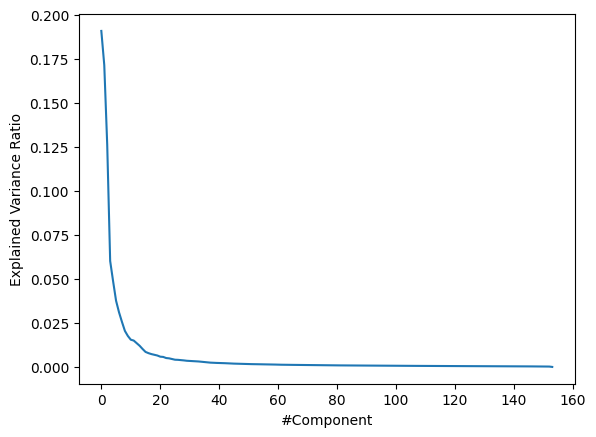

In [19]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('#Component')
plt.show()

##B

In [26]:
first4 = pca.explained_variance_ratio_[0:4]
last4 = pca.explained_variance_ratio_[-4:]
print("First 4: ")
print(first4)
print("Last 4: ")
print(last4)

First 4: 
[0.19071242 0.17131572 0.12607009 0.06013503]
Last 4: 
[2.51170117e-04 2.46942408e-04 2.04503269e-04 1.72894737e-30]


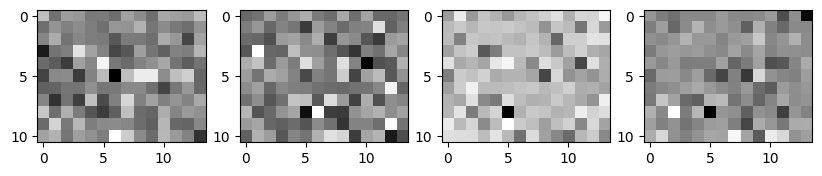

In [30]:
comps = pca.components_.T.reshape(11, 14, train_data.shape[1])
plt.figure(figsize=(10, 15))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(comps[:,:,i], 'gray')

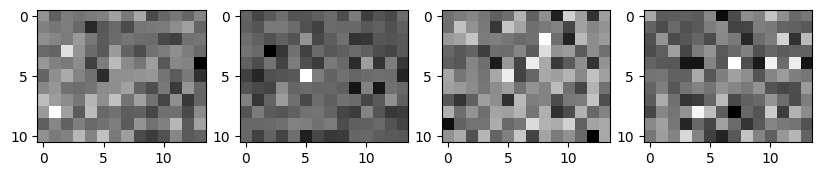

In [29]:
comps = pca.components_.T.reshape(11, 14, train_data.shape[1])
plt.figure(figsize=(10, 15))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(comps[:,:,-(i+1)], 'gray')

#Part 2

In [41]:
import pandas as pd
mypath = '/content/drive/MyDrive/HW5_ML/Q5_Datasets/part2/Fashion-MNIST/'
X_train = pd.read_csv(mypath+'trainData.csv')
y_train = pd.read_csv(mypath+'trainLabels.csv').to_numpy().reshape((X_train.shape[0],))
X_test = pd.read_csv(mypath+'testData.csv')
y_test = pd.read_csv(mypath+'testLabels.csv').to_numpy().reshape((X_test.shape[0],))

In [44]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

##A

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA().fit(X_train, y_train)

In [43]:
lda.explained_variance_ratio_

array([0.44564943, 0.21979057, 0.09304488, 0.07341581, 0.0609483 ,
       0.04322989, 0.03798863, 0.01602115, 0.00991134])

##B

In [45]:
def separability_measure(data1, data2):
    centroid1 = np.mean(data1, axis=0)
    centroid2 = np.mean(data2, axis=0)
    distance = np.linalg.norm(centroid1 - centroid2)
    return distance

In [46]:
transformed_X = lda.transform(X_train)

In [71]:
def compute_scatter_matrices(X, y):
    epsilon=1e-8
    class_labels = np.unique(y)
    num_classes = len(class_labels)
    num_features = X.shape[1]
    class_means = []
    for label in class_labels:
        class_means.append(np.mean(X[y == label], axis=0))
    Sw = np.zeros((num_features, num_features))
    for label, mean_vec in zip(class_labels, class_means):
        class_scatter = np.zeros((num_features, num_features))
        for row in X[y == label]:
            row, mean_vec = row.reshape(num_features, 1), mean_vec.reshape(num_features, 1)
            class_scatter += (row - mean_vec).dot((row - mean_vec).T)
        Sw += class_scatter
    Sw += epsilon * np.eye(num_features)
    overall_mean = np.mean(X, axis=0)
    Sb = np.zeros((num_features, num_features))
    for label, mean_vec in zip(class_labels, class_means):
        n = X[y == label, :].shape[0]
        mean_vec = mean_vec.reshape(num_features, 1)
        overall_mean = overall_mean.reshape(num_features, 1)
        Sb += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

    return Sw, Sb

def class_separability(X, y):
    Sw, Sb = compute_scatter_matrices(X, y)
    try:
        Sw_inv = np.linalg.inv(Sw)
    except np.linalg.LinAlgError:
        Sw_inv = np.linalg.pinv(Sw)
    product = np.dot(Sw_inv, Sb)
    trace = np.trace(product)

    return trace

In [69]:
sep = list()
for i in range(10):
  sep.append(class_separability(transformed_X[:,:(i+1)], y_train))

Text(0.5, 0, '#Features')

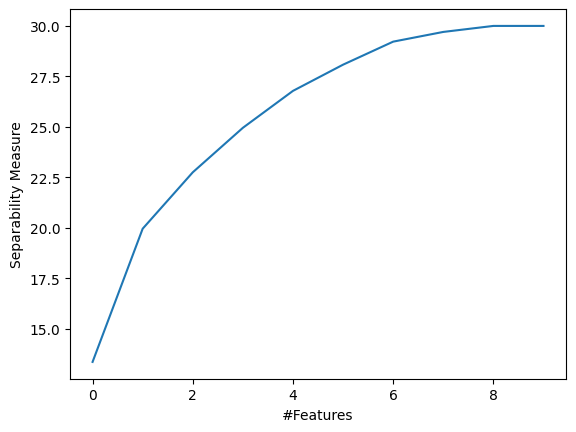

In [72]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(sep))), sep)
plt.ylabel('Separability Measure')
plt.xlabel('#Features')